In [ ]:
!pip install transformers-interpret

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.9/45.9 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 28.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 71.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 117.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 23.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 25.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 22.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/

In [ ]:
import pandas as pd
import torch
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, roc_auc_score, confusion_matrix, cohen_kappa_score, roc_curve
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.utils.class_weight import compute_class_weight
from sklearn.calibration import calibration_curve
from sklearn.isotonic import IsotonicRegression
from transformers_interpret import SequenceClassificationExplainer
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import matplotlib.pyplot as plt
import psutil
import time
from multiprocessing import Process
from tqdm import tqdm
import os
import numpy as np
import seaborn as sns
os.environ['CUDA_VISIBLE_DEVICES'] = '0, 1'

In [ ]:
torch.cuda.is_available()
torch.cuda.empty_cache()

In [ ]:
#monitor resource utilisation
def monitor_resources(interval):
    while True:
        #Get CPU utilisation
        cpu_percent = psutil.cpu_percent(interval=interval)
        print(f"CPU utilization: {cpu_percent}%")
        # Get memory utilization
        memory = psutil.virtual_memory()
        memory_percent = memory.percent
        memory_total = round(memory.total / (1024 ** 3), 2)
        memory_used = round(memory.used / (1024 ** 3), 2)
        print (f"Memory utilization: {memory_percent}%")
        print (f"Memory used: {memory_used} GB / {memory_total} GB")
        time.sleep(interval)

In [ ]:
#load pretrained GatorTron model and tokenizer
model_path = "UFNLP/gatortron-base"
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
if torch.cuda.device_count() > 1:
    print (f"using {torch.cuda.device_count()} GPU's for data parallelism.")
    model = torch.nn.DataParallel(model)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/534 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/713M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/713M [00:00<?, ?B/s]

Some weights of MegatronBertForSequenceClassification were not initialized from the model checkpoint at UFNLP/gatortron-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# load CSV file including letter information and class
csv_file_path = "/content/hip_radiology_reports_finalised_SYNTH.csv"
data = pd.read_csv(csv_file_path)
#prepare data for training and testing, change labels to binary format
texts = data["Interpretation"].tolist()
label_map = {"No": 0, "Yes": 1}
labels = data["operated_on"].map(label_map).tolist()
print(labels)
len(labels)

[1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 

1622

Maximum length 63
Minimum length 41
Avg length 50.89272503082614


<function matplotlib.pyplot.show(close=None, block=None)>

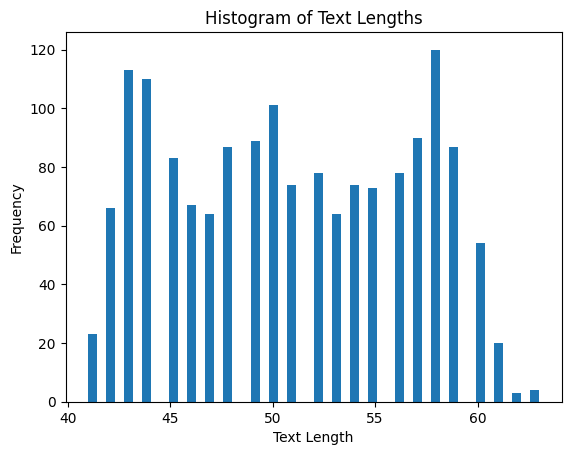

In [ ]:
#analyze text lengths in the dataset to decide on max_length parameter for truncation
text_lengths = [len(text.split()) for text in data ["Interpretation"]]
max_length = max(text_lengths)
min_length = min(text_lengths)
avg_length = sum(text_lengths) / len(text_lengths)
# print statistics
print("Maximum length", max_length)
print("Minimum length", min_length)
print("Avg length", avg_length)
plt.hist(text_lengths, bins = 50)
plt.xlabel("Text Length")
plt.ylabel("Frequency")
plt.title("Histogram of Text Lengths")
plt.show

In [ ]:
# set max length at 512, the maximum possible for BERT. We will use only_first truncation which ensures end of text is preserved
max_length = 150
accuracy_scores = []
f1_scores = []
recall_scores = []
precision_scores = []
roc_auc_scores = []
kappa_scores = []
confusion_matrices = []
train_losses_per_fold = []
val_losses_per_fold = []
train_losses = []
val_losses = []
calibration_results = []
calibration_fraction_of_positives = []
calibration_mean_predicted_value = []
all_predictions = []
chosen_threshold = 0.3

In [ ]:
# configure cross-validations
kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.1, random_state=42)
sum_conf_matrix = np.zeros((2, 2), dtype=int)

In [ ]:
def plot_loss(train_losses):
    plt.figure(figsize=(8, 6))
    plt.plot(range(1,len(train_losses) +1), train_losses, label="Training losses")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training loss over Epochs")
    plt.legend()
    plt.grid(True)
    plt.show

In [ ]:
# perform cross-validation. Split data then fine tune.
for fold, (train_index, test_index) in enumerate(kf.split(texts, labels)):
    print(f"Fold: {fold+1}")
    model = AutoModelForSequenceClassification.from_pretrained(model_path)
    model.to(device)
    if torch.cuda.device_count() > 1:
        model = torch.nn.DataParallel(model)
    train_texts = [texts[i] for i in train_index]
    train_labels = [labels[i] for i in train_index]
    test_texts = [texts[i] for i in test_index]
    test_labels = [labels[i] for i in test_index]
    #class weights here
    tokenized_inputs = tokenizer(train_texts, padding="max_length", truncation=True, max_length=max_length, return_tensors="pt")
    model.train()
    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-6)
    batch_size = 16
    epochs = 50
    num_samples = len(tokenized_inputs.input_ids)
    num_batches = (num_samples - 1) // batch_size + 1
    epoch_losses = []
    batch_inputs_list = []
    batch_labels_list = []
    for epoch in range(epochs):
        optimizer.zero_grad()
        for batch_idx in tqdm(range(num_batches), desc=f"Epoch {epoch+1}", unit = "batch"):
            optimizer.zero_grad()
            batch_start = batch_idx * batch_size
            batch_end = min((batch_idx + 1) * batch_size, num_samples)
            batch_inputs = {k: v[batch_start:batch_end] for k, v in tokenized_inputs.items()}
            batch_labels = torch.tensor(train_labels[batch_start:batch_end])
            batch_inputs = {k: v.to(device) for k, v in batch_inputs.items()}
            batch_labels = batch_labels.to(device)
            outputs = model(**batch_inputs, labels=batch_labels)
            # weight = class_weights for balance adjustment, not used #
            loss_fn = torch.nn.CrossEntropyLoss()
            loss = loss_fn(outputs.logits, batch_labels)
            if torch.cuda.device_count() > 1:
                loss = loss.mean()
            loss.backward()
            optimizer.step()
            epoch_losses.append(loss.item())
        train_losses.append(np.mean(epoch_losses))
        tqdm.write(f"Batch {batch_idx+1}/{num_batches}")

Fold: 1


Some weights of MegatronBertForSequenceClassification were not initialized from the model checkpoint at UFNLP/gatortron-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1: 100%|██████████| 68/68 [00:22<00:00,  3.01batch/s]


Batch 68/68


Epoch 2: 100%|██████████| 68/68 [00:22<00:00,  3.09batch/s]


Batch 68/68


Epoch 3: 100%|██████████| 68/68 [00:22<00:00,  3.09batch/s]


Batch 68/68


Epoch 4: 100%|██████████| 68/68 [00:21<00:00,  3.09batch/s]


Batch 68/68


Epoch 5: 100%|██████████| 68/68 [00:21<00:00,  3.09batch/s]


Batch 68/68


Epoch 6: 100%|██████████| 68/68 [00:21<00:00,  3.09batch/s]


Batch 68/68


Epoch 7: 100%|██████████| 68/68 [00:21<00:00,  3.09batch/s]


Batch 68/68


Epoch 8: 100%|██████████| 68/68 [00:21<00:00,  3.09batch/s]


Batch 68/68


Epoch 9: 100%|██████████| 68/68 [00:21<00:00,  3.09batch/s]


Batch 68/68


Epoch 10: 100%|██████████| 68/68 [00:22<00:00,  3.09batch/s]


Batch 68/68


Epoch 11: 100%|██████████| 68/68 [00:22<00:00,  3.09batch/s]


Batch 68/68


Epoch 12: 100%|██████████| 68/68 [00:21<00:00,  3.09batch/s]


Batch 68/68


Epoch 13: 100%|██████████| 68/68 [00:22<00:00,  3.09batch/s]


Batch 68/68


Epoch 14: 100%|██████████| 68/68 [00:22<00:00,  3.09batch/s]


Batch 68/68


Epoch 15: 100%|██████████| 68/68 [00:22<00:00,  3.09batch/s]


Batch 68/68


Epoch 16: 100%|██████████| 68/68 [00:22<00:00,  3.09batch/s]


Batch 68/68


Epoch 17: 100%|██████████| 68/68 [00:21<00:00,  3.09batch/s]


Batch 68/68


Epoch 18: 100%|██████████| 68/68 [00:22<00:00,  3.09batch/s]


Batch 68/68


Epoch 19: 100%|██████████| 68/68 [00:22<00:00,  3.09batch/s]


Batch 68/68


Epoch 20: 100%|██████████| 68/68 [00:22<00:00,  3.09batch/s]


Batch 68/68


Epoch 21: 100%|██████████| 68/68 [00:22<00:00,  3.09batch/s]


Batch 68/68


Epoch 22: 100%|██████████| 68/68 [00:22<00:00,  3.09batch/s]


Batch 68/68


Epoch 23: 100%|██████████| 68/68 [00:22<00:00,  3.09batch/s]


Batch 68/68


Epoch 24: 100%|██████████| 68/68 [00:22<00:00,  3.09batch/s]


Batch 68/68


Epoch 25: 100%|██████████| 68/68 [00:22<00:00,  3.09batch/s]


Batch 68/68


Epoch 26: 100%|██████████| 68/68 [00:22<00:00,  3.09batch/s]


Batch 68/68


Epoch 27: 100%|██████████| 68/68 [00:22<00:00,  3.09batch/s]


Batch 68/68


Epoch 28: 100%|██████████| 68/68 [00:21<00:00,  3.09batch/s]


Batch 68/68


Epoch 29: 100%|██████████| 68/68 [00:21<00:00,  3.09batch/s]


Batch 68/68


Epoch 30: 100%|██████████| 68/68 [00:21<00:00,  3.09batch/s]


Batch 68/68


Epoch 31: 100%|██████████| 68/68 [00:21<00:00,  3.09batch/s]


Batch 68/68


Epoch 32: 100%|██████████| 68/68 [00:22<00:00,  3.07batch/s]


Batch 68/68


Epoch 33: 100%|██████████| 68/68 [00:21<00:00,  3.09batch/s]


Batch 68/68


Epoch 34: 100%|██████████| 68/68 [00:21<00:00,  3.09batch/s]


Batch 68/68


Epoch 35: 100%|██████████| 68/68 [00:22<00:00,  3.09batch/s]


Batch 68/68


Epoch 36: 100%|██████████| 68/68 [00:21<00:00,  3.09batch/s]


Batch 68/68


Epoch 37: 100%|██████████| 68/68 [00:22<00:00,  3.09batch/s]


Batch 68/68


Epoch 38: 100%|██████████| 68/68 [00:22<00:00,  3.09batch/s]


Batch 68/68


Epoch 39: 100%|██████████| 68/68 [00:21<00:00,  3.09batch/s]


Batch 68/68


Epoch 40: 100%|██████████| 68/68 [00:21<00:00,  3.09batch/s]


Batch 68/68


Epoch 41: 100%|██████████| 68/68 [00:21<00:00,  3.09batch/s]


Batch 68/68


Epoch 42: 100%|██████████| 68/68 [00:21<00:00,  3.09batch/s]


Batch 68/68


Epoch 43: 100%|██████████| 68/68 [00:22<00:00,  3.09batch/s]


Batch 68/68


Epoch 44: 100%|██████████| 68/68 [00:22<00:00,  3.09batch/s]


Batch 68/68


Epoch 45: 100%|██████████| 68/68 [00:22<00:00,  3.09batch/s]


Batch 68/68


Epoch 46: 100%|██████████| 68/68 [00:22<00:00,  3.09batch/s]


Batch 68/68


Epoch 47: 100%|██████████| 68/68 [00:22<00:00,  3.09batch/s]


Batch 68/68


Epoch 48: 100%|██████████| 68/68 [00:22<00:00,  3.09batch/s]


Batch 68/68


Epoch 49: 100%|██████████| 68/68 [00:22<00:00,  3.09batch/s]


Batch 68/68


Epoch 50: 100%|██████████| 68/68 [00:22<00:00,  3.09batch/s]


Batch 68/68
Fold: 2


Some weights of MegatronBertForSequenceClassification were not initialized from the model checkpoint at UFNLP/gatortron-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1: 100%|██████████| 68/68 [00:22<00:00,  3.09batch/s]


Batch 68/68


Epoch 2: 100%|██████████| 68/68 [00:21<00:00,  3.09batch/s]


Batch 68/68


Epoch 3: 100%|██████████| 68/68 [00:21<00:00,  3.09batch/s]


Batch 68/68


Epoch 4: 100%|██████████| 68/68 [00:22<00:00,  3.09batch/s]


Batch 68/68


Epoch 5: 100%|██████████| 68/68 [00:22<00:00,  3.09batch/s]


Batch 68/68


Epoch 6: 100%|██████████| 68/68 [00:22<00:00,  3.09batch/s]


Batch 68/68


Epoch 7: 100%|██████████| 68/68 [00:22<00:00,  3.09batch/s]


Batch 68/68


Epoch 8: 100%|██████████| 68/68 [00:22<00:00,  3.09batch/s]


Batch 68/68


Epoch 9: 100%|██████████| 68/68 [00:22<00:00,  3.09batch/s]


Batch 68/68


Epoch 10: 100%|██████████| 68/68 [00:21<00:00,  3.09batch/s]


Batch 68/68


Epoch 11: 100%|██████████| 68/68 [00:22<00:00,  3.09batch/s]


Batch 68/68


Epoch 12: 100%|██████████| 68/68 [00:22<00:00,  3.09batch/s]


Batch 68/68


Epoch 13: 100%|██████████| 68/68 [00:21<00:00,  3.09batch/s]


Batch 68/68


Epoch 14: 100%|██████████| 68/68 [00:22<00:00,  3.09batch/s]


Batch 68/68


Epoch 15: 100%|██████████| 68/68 [00:22<00:00,  3.09batch/s]


Batch 68/68


Epoch 16: 100%|██████████| 68/68 [00:22<00:00,  3.09batch/s]


Batch 68/68


Epoch 17: 100%|██████████| 68/68 [00:22<00:00,  3.09batch/s]


Batch 68/68


Epoch 18: 100%|██████████| 68/68 [00:21<00:00,  3.09batch/s]


Batch 68/68


Epoch 19: 100%|██████████| 68/68 [00:22<00:00,  3.09batch/s]


Batch 68/68


Epoch 20: 100%|██████████| 68/68 [00:22<00:00,  3.09batch/s]


Batch 68/68


Epoch 21: 100%|██████████| 68/68 [00:22<00:00,  3.09batch/s]


Batch 68/68


Epoch 22: 100%|██████████| 68/68 [00:22<00:00,  3.09batch/s]


Batch 68/68


Epoch 23: 100%|██████████| 68/68 [00:21<00:00,  3.09batch/s]


Batch 68/68


Epoch 24: 100%|██████████| 68/68 [00:22<00:00,  3.09batch/s]


Batch 68/68


Epoch 25: 100%|██████████| 68/68 [00:22<00:00,  3.07batch/s]


Batch 68/68


Epoch 26: 100%|██████████| 68/68 [00:22<00:00,  3.09batch/s]


Batch 68/68


Epoch 27: 100%|██████████| 68/68 [00:22<00:00,  3.09batch/s]


Batch 68/68


Epoch 28: 100%|██████████| 68/68 [00:22<00:00,  3.09batch/s]


Batch 68/68


Epoch 29: 100%|██████████| 68/68 [00:21<00:00,  3.09batch/s]


Batch 68/68


Epoch 30: 100%|██████████| 68/68 [00:22<00:00,  3.09batch/s]


Batch 68/68


Epoch 31: 100%|██████████| 68/68 [00:22<00:00,  3.09batch/s]


Batch 68/68


Epoch 32: 100%|██████████| 68/68 [00:22<00:00,  3.09batch/s]


Batch 68/68


Epoch 33: 100%|██████████| 68/68 [00:22<00:00,  3.09batch/s]


Batch 68/68


Epoch 34: 100%|██████████| 68/68 [00:22<00:00,  3.09batch/s]


Batch 68/68


Epoch 35: 100%|██████████| 68/68 [00:22<00:00,  3.09batch/s]


Batch 68/68


Epoch 36: 100%|██████████| 68/68 [00:21<00:00,  3.09batch/s]


Batch 68/68


Epoch 37: 100%|██████████| 68/68 [00:22<00:00,  3.09batch/s]


Batch 68/68


Epoch 38: 100%|██████████| 68/68 [00:22<00:00,  3.09batch/s]


Batch 68/68


Epoch 39: 100%|██████████| 68/68 [00:22<00:00,  3.09batch/s]


Batch 68/68


Epoch 40: 100%|██████████| 68/68 [00:22<00:00,  3.09batch/s]


Batch 68/68


Epoch 41: 100%|██████████| 68/68 [00:22<00:00,  3.09batch/s]


Batch 68/68


Epoch 42: 100%|██████████| 68/68 [00:22<00:00,  3.09batch/s]


Batch 68/68


Epoch 43: 100%|██████████| 68/68 [00:22<00:00,  3.09batch/s]


Batch 68/68


Epoch 44: 100%|██████████| 68/68 [00:21<00:00,  3.09batch/s]


Batch 68/68


Epoch 45: 100%|██████████| 68/68 [00:22<00:00,  3.09batch/s]


Batch 68/68


Epoch 46: 100%|██████████| 68/68 [00:21<00:00,  3.09batch/s]


Batch 68/68


Epoch 47: 100%|██████████| 68/68 [00:22<00:00,  3.09batch/s]


Batch 68/68


Epoch 48: 100%|██████████| 68/68 [00:22<00:00,  3.09batch/s]


Batch 68/68


Epoch 49: 100%|██████████| 68/68 [00:22<00:00,  3.09batch/s]


Batch 68/68


Epoch 50: 100%|██████████| 68/68 [00:22<00:00,  3.09batch/s]


Batch 68/68
Fold: 3


Some weights of MegatronBertForSequenceClassification were not initialized from the model checkpoint at UFNLP/gatortron-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1: 100%|██████████| 68/68 [00:22<00:00,  3.08batch/s]


Batch 68/68


Epoch 2: 100%|██████████| 68/68 [00:22<00:00,  3.09batch/s]


Batch 68/68


Epoch 3: 100%|██████████| 68/68 [00:22<00:00,  3.09batch/s]


Batch 68/68


Epoch 4: 100%|██████████| 68/68 [00:22<00:00,  3.09batch/s]


Batch 68/68


Epoch 5: 100%|██████████| 68/68 [00:22<00:00,  3.09batch/s]


Batch 68/68


Epoch 6: 100%|██████████| 68/68 [00:22<00:00,  3.09batch/s]


Batch 68/68


Epoch 7: 100%|██████████| 68/68 [00:22<00:00,  3.09batch/s]


Batch 68/68


Epoch 8: 100%|██████████| 68/68 [00:22<00:00,  3.09batch/s]


Batch 68/68


Epoch 9: 100%|██████████| 68/68 [00:22<00:00,  3.09batch/s]


Batch 68/68


Epoch 10: 100%|██████████| 68/68 [00:22<00:00,  3.09batch/s]


Batch 68/68


Epoch 11: 100%|██████████| 68/68 [00:22<00:00,  3.09batch/s]


Batch 68/68


Epoch 12: 100%|██████████| 68/68 [00:22<00:00,  3.09batch/s]


Batch 68/68


Epoch 13: 100%|██████████| 68/68 [00:22<00:00,  3.09batch/s]


Batch 68/68


Epoch 14: 100%|██████████| 68/68 [00:22<00:00,  3.09batch/s]


Batch 68/68


Epoch 15: 100%|██████████| 68/68 [00:22<00:00,  3.09batch/s]


Batch 68/68


Epoch 16: 100%|██████████| 68/68 [00:22<00:00,  3.09batch/s]


Batch 68/68


Epoch 17: 100%|██████████| 68/68 [00:22<00:00,  3.09batch/s]


Batch 68/68


Epoch 18: 100%|██████████| 68/68 [00:22<00:00,  3.09batch/s]


Batch 68/68


Epoch 19: 100%|██████████| 68/68 [00:22<00:00,  3.06batch/s]


Batch 68/68


Epoch 20: 100%|██████████| 68/68 [00:22<00:00,  3.09batch/s]


Batch 68/68


Epoch 21: 100%|██████████| 68/68 [00:22<00:00,  3.09batch/s]


Batch 68/68


Epoch 22: 100%|██████████| 68/68 [00:22<00:00,  3.09batch/s]


Batch 68/68


Epoch 23: 100%|██████████| 68/68 [00:22<00:00,  3.09batch/s]


Batch 68/68


Epoch 24: 100%|██████████| 68/68 [00:22<00:00,  3.09batch/s]


Batch 68/68


Epoch 25: 100%|██████████| 68/68 [00:22<00:00,  3.09batch/s]


Batch 68/68


Epoch 26: 100%|██████████| 68/68 [00:22<00:00,  3.09batch/s]


Batch 68/68


Epoch 27: 100%|██████████| 68/68 [00:22<00:00,  3.09batch/s]


Batch 68/68


Epoch 28: 100%|██████████| 68/68 [00:22<00:00,  3.09batch/s]


Batch 68/68


Epoch 29: 100%|██████████| 68/68 [00:22<00:00,  3.09batch/s]


Batch 68/68


Epoch 30: 100%|██████████| 68/68 [00:22<00:00,  3.09batch/s]


Batch 68/68


Epoch 31: 100%|██████████| 68/68 [00:22<00:00,  3.09batch/s]


Batch 68/68


Epoch 32: 100%|██████████| 68/68 [00:22<00:00,  3.09batch/s]


Batch 68/68


Epoch 33: 100%|██████████| 68/68 [00:22<00:00,  3.09batch/s]


Batch 68/68


Epoch 34: 100%|██████████| 68/68 [00:22<00:00,  3.09batch/s]


Batch 68/68


Epoch 35: 100%|██████████| 68/68 [00:22<00:00,  3.09batch/s]


Batch 68/68


Epoch 36: 100%|██████████| 68/68 [00:22<00:00,  3.09batch/s]


Batch 68/68


Epoch 37: 100%|██████████| 68/68 [00:22<00:00,  3.09batch/s]


Batch 68/68


Epoch 38: 100%|██████████| 68/68 [00:22<00:00,  3.09batch/s]


Batch 68/68


Epoch 39: 100%|██████████| 68/68 [00:22<00:00,  3.09batch/s]


Batch 68/68


Epoch 40: 100%|██████████| 68/68 [00:21<00:00,  3.09batch/s]


Batch 68/68


Epoch 41: 100%|██████████| 68/68 [00:22<00:00,  3.09batch/s]


Batch 68/68


Epoch 42: 100%|██████████| 68/68 [00:22<00:00,  3.09batch/s]


Batch 68/68


Epoch 43: 100%|██████████| 68/68 [00:22<00:00,  3.09batch/s]


Batch 68/68


Epoch 44: 100%|██████████| 68/68 [00:22<00:00,  3.09batch/s]


Batch 68/68


Epoch 45: 100%|██████████| 68/68 [00:22<00:00,  3.09batch/s]


Batch 68/68


Epoch 46: 100%|██████████| 68/68 [00:22<00:00,  3.09batch/s]


Batch 68/68


Epoch 47: 100%|██████████| 68/68 [00:22<00:00,  3.09batch/s]


Batch 68/68


Epoch 48: 100%|██████████| 68/68 [00:22<00:00,  3.09batch/s]


Batch 68/68


Epoch 49: 100%|██████████| 68/68 [00:22<00:00,  3.09batch/s]


Batch 68/68


Epoch 50: 100%|██████████| 68/68 [00:22<00:00,  3.09batch/s]

Batch 68/68


In [ ]:
model.eval()
test_inputs = []
test_outputs = []
with torch.no_grad():
    for i in range(0, len(test_texts), batch_size):
        batch_texts = test_texts[i:i + batch_size]
        test_batch_labels = torch.tensor(test_labels[i:i + batch_size])
        tokenized_test_inputs = tokenizer(batch_texts, padding="max_length", truncation=True, max_length=max_length, return_tensors="pt")
        batch_inputs2 = {k: v.to(device) for k, v in tokenized_test_inputs.items()}
        test_batch_labels = test_batch_labels.to(device)
        batch_outputs = model(**batch_inputs2)
        test_inputs.append(batch_inputs2)
        test_outputs.append(batch_outputs)
train_losses_per_fold.append(train_losses)
val_losses_per_fold.append(val_losses)
test_inputs = {k: torch.cat([t[k] for t in test_inputs], dim=0) for k in test_inputs[0]}
test_outputs = torch.cat([t.logits for t in test_outputs], dim=0)
# argmax predictions here and remove predictions below
probabilities = torch.softmax(test_outputs, dim=-1).cpu().detach().numpy()[:, 1]
#isotonic regression
isotonic_regressor = IsotonicRegression(out_of_bounds='clip')
calibrated_probs = isotonic_regressor.fit_transform(probabilities, test_labels)
predictions = (calibrated_probs >= chosen_threshold).astype(int).tolist()
fraction_of_positives, mean_predicted_value = calibration_curve(test_labels, calibrated_probs, n_bins=5)
calibration_fraction_of_positives.append(fraction_of_positives)
calibration_mean_predicted_value.append(mean_predicted_value)
accuracy = accuracy_score(test_labels, predictions)
f1 = f1_score(test_labels, predictions)
recall = recall_score(test_labels, predictions)
precision = precision_score(test_labels, predictions)
roc_auc = roc_auc_score(test_labels, predictions)
kappa = cohen_kappa_score(test_labels, predictions)
conf_matrix = confusion_matrix(test_labels, predictions)
accuracy_scores.append(accuracy)
f1_scores.append(f1)
recall_scores.append(recall)
precision_scores.append(precision)
roc_auc_scores.append(roc_auc)
kappa_scores.append(kappa)
confusion_matrices.append(conf_matrix)
sum_conf_matrix += conf_matrix
print(f"Accuracy: {accuracy:.4f}")
print(f"F1: {f1:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")
print(f"AUROC: {roc_auc:.4f}")
print(f"Kappa: {kappa:.4f}")
print("Confusion Matrix:")
print(conf_matrix)
print("Fold completed.")
if isinstance(model, torch.nn.DataParallel):
    model.module.save_pretrained(f"Radiology Reports/model_fold{fold+1}")
else:
    model.save_pretrained(f"Radiology Reports/model_fold{fold+1}")
tokenizer.save_vocabulary(f"Radiology Reports/model_fold{fold+1}")

Accuracy: 0.4593
F1: 0.5244
Recall: 0.8564
Precision: 0.3779
AUROC: 0.5518
Kappa: 0.0800
Confusion Matrix:
[[ 87 265]
 [ 27 161]]
Fold completed.


('Radiology Reports/model_fold3/vocab.txt',)

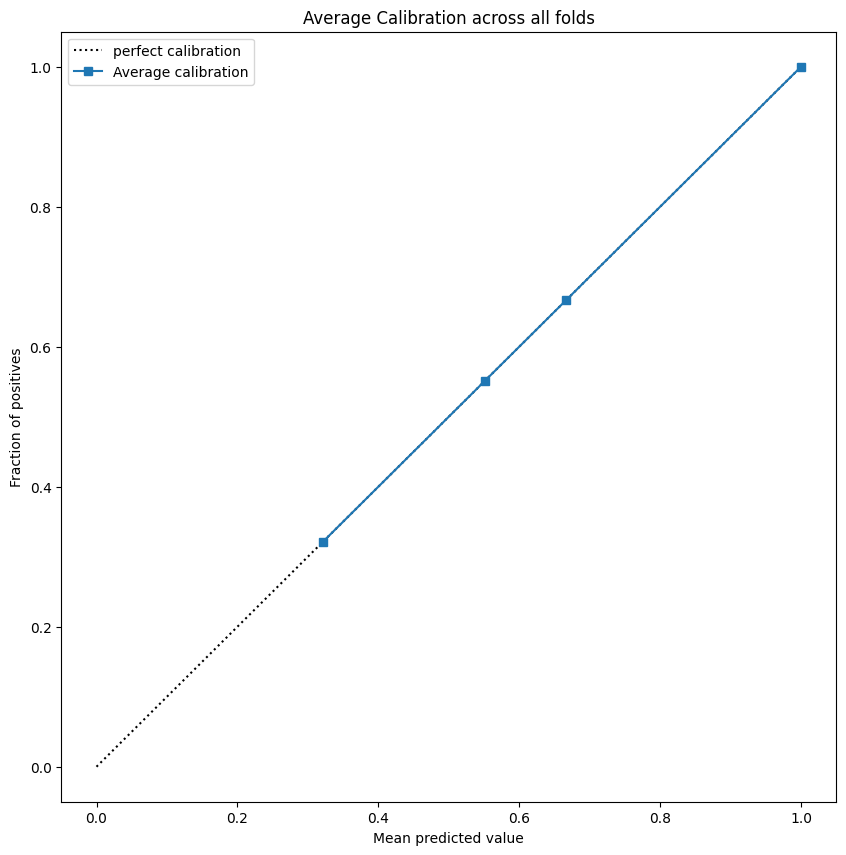

In [ ]:
#text attribution
average_conf_matrix = sum_conf_matrix / len(confusion_matrices)
mean_train_losses = np.mean(train_losses_per_fold, axis=0)
mean_val_losses = np.mean(val_losses_per_fold, axis=0)
calibration_fraction_of_positives = np.array(calibration_fraction_of_positives)
calibration_mean_predicted_value = np.array(calibration_mean_predicted_value)
average_fraction_of_positives = np.mean(calibration_fraction_of_positives, axis=0)
average_mean_predicted_value = np.mean(calibration_mean_predicted_value, axis=0)
plt.figure(figsize=(10,10))
plt.plot([0, 1], [0, 1], "k:", label="perfect calibration")
plt.plot(average_mean_predicted_value, average_fraction_of_positives, "s-", label="Average calibration")
plt.ylabel("Fraction of positives")
plt.xlabel("Mean predicted value")
plt.title("Average Calibration across all folds")
plt.legend()
plt.show()

In [ ]:
print("\nOverall Evaluation Metrics")
print(f"Average accuracy: {sum(accuracy_scores) / len(accuracy_scores):.4f}")
print(f"Average F1: {sum(f1_scores) / len(f1_scores):.4f}")
print(f"Average recall: {sum(recall_scores) / len(recall_scores):.4f}")
print(f"Average precision: {sum(precision_scores) / len(precision_scores):.4f}")
print(f"Average AUROC: {sum(roc_auc_scores) / len(roc_auc_scores):.4f}")
print(f"Average Kappa: {sum(kappa_scores) / len(kappa_scores):.4f}")
print(f"Average Confusion matrix:")
print(average_conf_matrix)


Overall Evaluation Metrics
Average accuracy: 0.4593
Average F1: 0.5244
Average recall: 0.8564
Average precision: 0.3779
Average AUROC: 0.5518
Average Kappa: 0.0800
Average Confusion matrix:
[[ 87. 265.]
 [ 27. 161.]]


In [ ]:
from scipy.stats import sem, t
import numpy as np
def calculate_standard_error(values, variable_name="Variable"):
    mean_val = np.mean(values)
    standard_error = sem(values)
    dof = len(values) - 1
    confidence_interval = t.interval(0.95, dof, loc=mean_val, scale=standard_error)
    print(f"Standard Error of {variable_name}: {standard_error}")
    print(f"95% Confidence Interval of {variable_name}: {confidence_interval}")
calculate_standard_error(accuracy_scores, "Accuracy")
calculate_standard_error(f1_scores, "F1 Score")
calculate_standard_error(recall_scores, "Recall")
calculate_standard_error(precision_scores, "Precision")
calculate_standard_error(roc_auc_scores, "AUROC")
calculate_standard_error(kappa_scores, "Kappa")

Standard Error of Accuracy: nan
95% Confidence Interval of Accuracy: (nan, nan)
Standard Error of F1 Score: nan
95% Confidence Interval of F1 Score: (nan, nan)
Standard Error of Recall: nan
95% Confidence Interval of Recall: (nan, nan)
Standard Error of Precision: nan
95% Confidence Interval of Precision: (nan, nan)
Standard Error of AUROC: nan
95% Confidence Interval of AUROC: (nan, nan)
Standard Error of Kappa: nan
95% Confidence Interval of Kappa: (nan, nan)


/tmp/ipython-input-58227420.py:5: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  standard_error = sem(values)


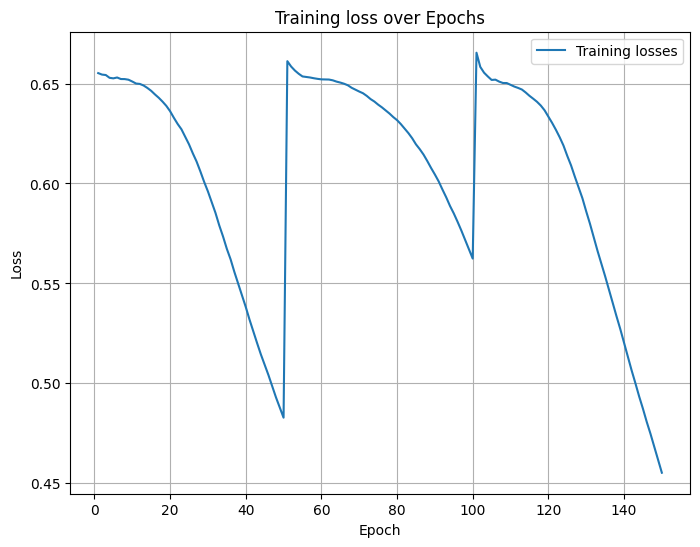

In [ ]:
plot_loss(train_losses)
plt.savefig('Loss.png', dpi=300)

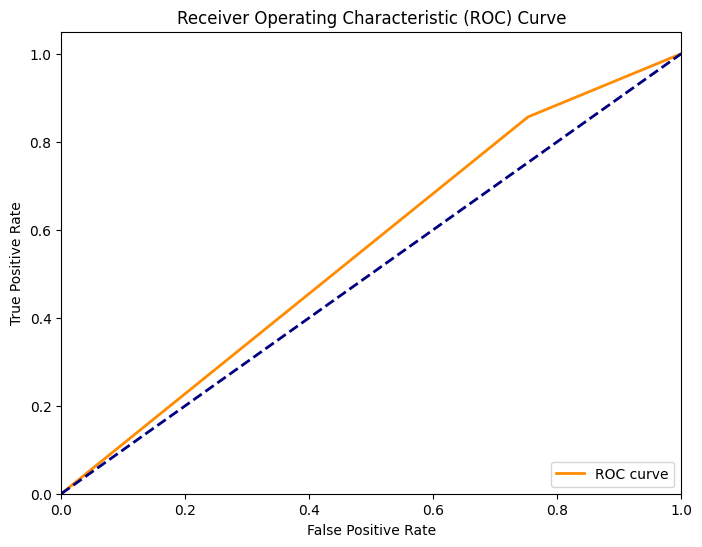

In [ ]:
fpr, tpr, thresholds = roc_curve(test_labels, predictions)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve')
plt.plot([0,1], [0,1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.savefig('ROC_Curve_Trained.png', dpi=300)
plt.show()

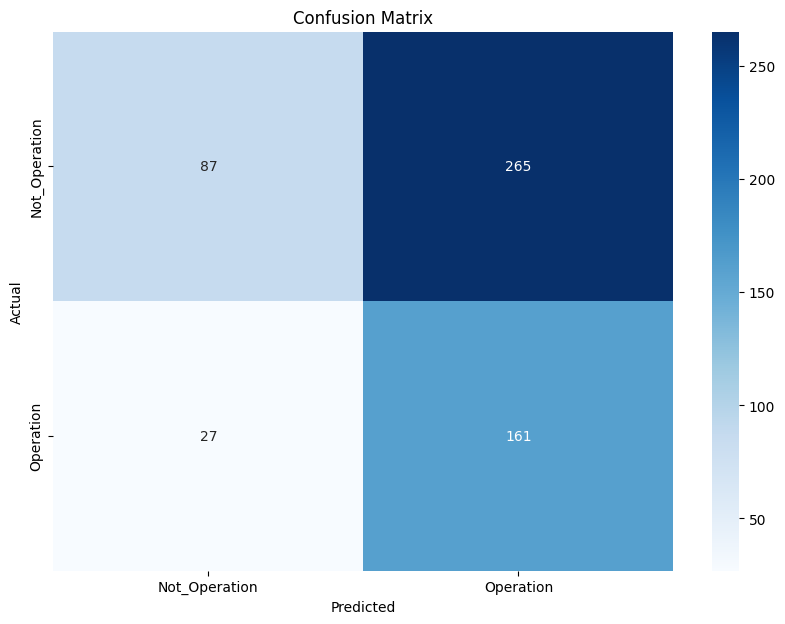

In [ ]:
plt.figure(figsize=(10, 7))
sns.heatmap(average_conf_matrix, annot=True, fmt='g', cmap='Blues',
xticklabels=['Not_Operation', 'Operation'],
yticklabels=['Not_Operation', 'Operation'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.savefig('Confusion_Matrix_Trained.png', dpi=300)
plt.show()

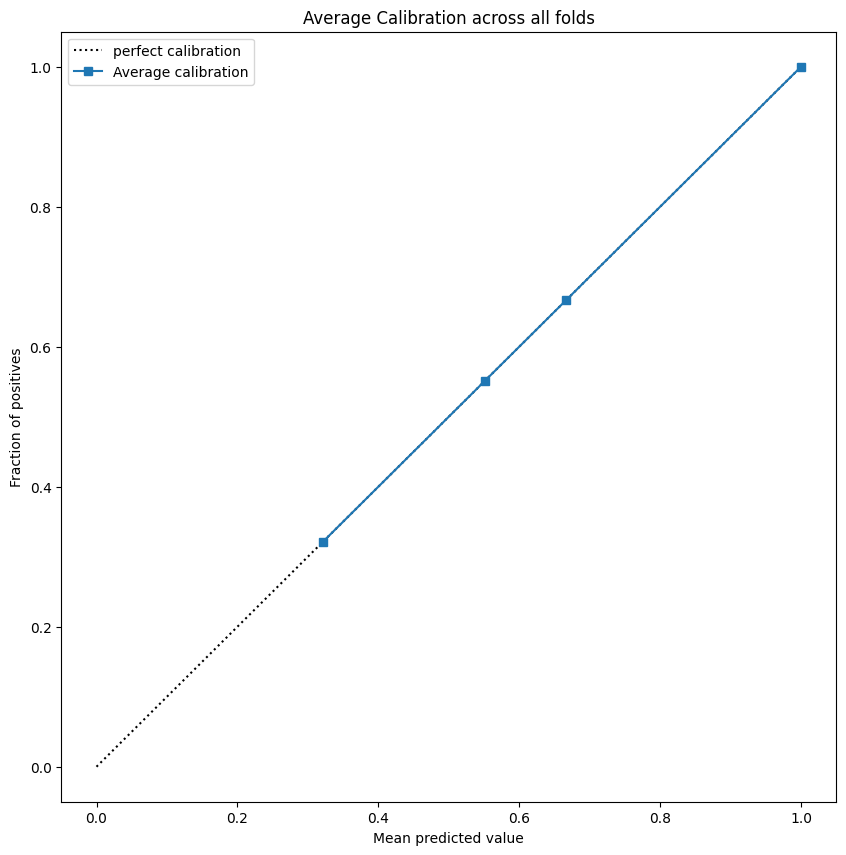

In [ ]:
plt.figure(figsize=(10,10))
plt.plot([0, 1], [0, 1], "k:", label="perfect calibration")
plt.plot(average_mean_predicted_value, average_fraction_of_positives, "s-", label="Average calibration")
plt.ylabel("Fraction of positives")
plt.xlabel("Mean predicted value")
plt.title("Average Calibration across all folds")
plt.legend()
plt.savefig('Calibration_Trained.png', dpi=300)
plt.show()

In [ ]:
if isinstance(model, torch.nn.DataParallel):
    model.module.save_pretrained(f"model_fold{fold+1}")
else:
    model.save_pretrained(f"model_fold{fold+1}")
calibration_fraction_of_positives

array([[0.32091097, 0.55102041, 0.66666667, 1.        ]])

In [ ]:
class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights)
loss = loss_fn(outputs.logits, batch_labels)

In [ ]:
# if want to use argmax for predictions
predictions = test_outputs.argmax(dim=-1).cpu().numpy().tolist()

In [ ]:
original_model = AutoModelForSequenceClassification.from_pretrained(f"Radiology Reports/model_fold{fold+1}")
original_model.to(device)
explainer = SequenceClassificationExplainer(original_model, tokenizer)
for text in test_texts[:3]:
    attribution = explainer(text)
    print(f"Text: {text}")
    print("Attribution")
    print(attribution)

Text: Exam Date: 28.09.2019
Exam: XR Pelvis, XR Hip Rt
Technique: AP and lateral views of both hips.
Clinical information: Hip pain.
Findings: No periprosthetic lucency; components well aligned. Sacroiliac joints normal. Pubic symphysis unremarkable. Moderate osteoarthritic change, worse on the right. No acute fracture or dislocation identified.
Reported by: Reporting Radiographer - Jacob Fraser
Verified date: 30/09/2019
Attribution
[('[CLS]', 0.0), ('exam', 0.08846572786569595), ('date', -0.029921112582087517), (':', 0.009726160205900669), ('28', 0.10351003706455231), ('.', 0.003526323242112994), ('09', -0.08663306385278702), ('.', -0.08604636788368225), ('2019', 0.09582480043172836), ('exam', 0.04545827955007553), (':', 0.02255077473819256), ('xr', 0.1470554620027542), ('pelvis', 0.05161764472723007), (',', -0.03171302005648613), ('xr', 0.05730928108096123), ('hip', -0.011210169643163681), ('rt', 0.17390193045139313), ('technique', 0.13547320663928986), (':', 0.05692015215754509), ('

In [ ]:
from transformers import AutoModel, AutoTokenizer, AutoConfig

tokenizer= AutoTokenizer.from_pretrained('UFNLP/gatortron-base')
config=AutoConfig.from_pretrained('UFNLP/gatortron-base')
mymodel=AutoModel.from_pretrained('UFNLP/gatortron-base')

encoded_input=tokenizer("Bone scan:  Negative for distant metastasis.", return_tensors="pt")
encoded_output = mymodel(**encoded_input)
print (encoded_output)

config.json:   0%|          | 0.00/534 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/713M [00:00<?, ?B/s]

BaseModelOutputWithPoolingAndCrossAttentions(last_hidden_state=tensor([[[-0.5924,  0.1630,  0.6396,  ...,  0.7088, -0.3500, -0.0225],
         [-0.7186,  0.7437,  0.4885,  ...,  0.4310, -0.2094,  0.2431],
         [-0.4013,  0.2324,  0.3076,  ...,  0.1691, -0.4022,  0.0109],
         ...,
         [ 0.0802,  0.5385, -0.0017,  ..., -0.2361, -0.2471,  0.0284],
         [-0.0093,  0.0155, -0.0356,  ..., -0.0494, -0.1186, -0.0447],
         [-0.5201, -0.0494,  0.9739,  ...,  0.5900, -0.1954,  0.0582]]],
       grad_fn=<NativeLayerNormBackward0>), pooler_output=tensor([[-0.3146, -0.2337, -0.2550,  ...,  0.2328,  0.0557,  0.1983]],
       grad_fn=<TanhBackward0>), hidden_states=None, past_key_values=None, attentions=None, cross_attentions=None)


Model: The model used is GatorTron (specifically UFNLP/gatortron-base), which is a pre-trained language model. It was fine-tuned for a sequence classification task.

Task: The task is a binary classification of radiology reports. The goal is to predict whether a patient was "operated on" or "not operated on" based on the text in the report. The labels used were "Yes" (1) for operated and "No" (0) for not operated.

Training and Evaluation: The model was trained and evaluated using 3-fold stratified cross-validation. The data was split into training and testing sets for each fold, ensuring that the proportion of each class was maintained in each split.

Training Parameters:
Optimizer: AdamW with a learning rate of 2e-6.
Batch Size: 16
Epochs: 50
Max Token Length: 150 (used for truncation during tokenization)
Evaluation Metrics: The performance was evaluated using several metrics, averaged across the 3 folds:
Accuracy
F1 Score
Recall
Precision
AUROC (Area Under the Receiver Operating Characteristic Curve)
Cohen's Kappa
Performance: Based on the averaged metrics from the 3-fold cross-validation:

Average Accuracy: 0.4593
Average F1 Score: 0.5244
Average Recall: 0.8564
Average Precision: 0.3779
Average AUROC: 0.5518
Average Kappa: 0.0800
The average confusion matrix shows:

True Negatives (Actual: Not Operated, Predicted: Not Operated): 87
False Positives (Actual: Not Operated, Predicted: Operated): 265
False Negatives (Actual: Operated, Predicted: Not Operated): 27
True Positives (Actual: Operated, Predicted: Operated): 161
Summary of Performance: The model's performance, as indicated by these metrics, is relatively low.

An Accuracy of 0.4593 suggests that the model correctly classifies slightly less than half of the instances.
The F1 score of 0.5244 indicates a balance between precision and recall, but it's not very high.
The high Recall (0.8564) suggests that the model is good at identifying most of the actual "operated on" cases.
However, the low Precision (0.3779) indicates that when the model predicts "operated on", it is often incorrect (a high number of False Positives).
The AUROC of 0.5518 is only slightly better than random chance (0.5).
The Kappa score of 0.0800 suggests very slight agreement with random chance.
The confusion matrix highlights that the model has a significant number of false positives, meaning it frequently predicts "Operated" when the actual outcome was "Not Operated".

Potential Considerations:

The performance metrics suggest that the model is not performing well on this classification task.
The imbalance in the confusion matrix (many False Positives) could be related to the class distribution in the dataset or the model's difficulty in distinguishing between the two classes based on the text.
Further analysis, potentially using techniques like class weighting or exploring different model architectures or hyperparameters, might be needed to improve performance.